## <u>*Regression Modelling for Severity as a Target Feature*</u>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)
import seaborn as sns;sns.set()
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score,mean_absolute_error,accuracy_score,root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor,BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost import XGBRFRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV,cross_val_score,KFold
from sklearn.preprocessing import LabelEncoder,StandardScaler
from tqdm import tqdm
from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK,Trials

In [2]:
df=pd.read_csv(r"C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/Data_Sets/data_car.csv")
df=df.drop(["X_OBSTAT_","clm"],axis=1)

In [3]:
df["agecat"]=df["agecat"].astype("object")
df["veh_age"]=df["veh_age"].astype("object")
df["numclaims"]=df["numclaims"].astype("object")

---

*Date preprocessing*

In [4]:
categories_encoder=LabelEncoder()
for col in df:
    if col in list(df.select_dtypes(include="object").columns):
        df[col]=categories_encoder.fit_transform(df[col])

In [5]:
df=df[df["claimcst0"]>0]
df.head()

,veh_value,exposure,numclaims,claimcst0,veh_body,veh_age,gender,area,agecat
14,1.66,0.484600,1,669.509999,9,2,1,1,5
16,1.51,0.993840,1,806.609999,9,2,0,5,3
17,0.76,0.539357,1,401.805451,3,2,1,2,3
40,1.89,0.654346,2,1811.709997,10,2,1,5,1
64,4.06,0.851472,1,5434.439987,10,1,1,5,2


*Define x and y*

In [6]:
x=df.drop(["claimcst0"],axis=1)
y=df["claimcst0"]

*Splitting data into training and testing subsets*

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x,y ,test_size= 0.20)

print("Train data shape of X = % s and Y = % s : "%(
	x_train.shape, y_train.shape))

print("Test data shape of X = % s and Y = % s : "%(
	x_test.shape, y_test.shape))

Train data shape of X = (3699, 8) and Y = (3699,) : 
Test data shape of X = (925, 8) and Y = (925,) : 


*Data Scalling*

In [8]:
sc=StandardScaler()
x_train=sc.fit_transform(x_train)
x_test=sc.transform(x_test)

---

## *Hyperparamers tunning*

* *Defining models and its parameters*

In [11]:
models = {
                "RandomForestRegressor": RandomForestRegressor(),
                "DecisionTreeRegressor": DecisionTreeRegressor(),
                "XGBRFRegressor": XGBRFRegressor(),
                "GradientBoostingRegressor":GradientBoostingRegressor(),
                "AdaBoostRegressor": AdaBoostRegressor()
        
}

search_spaces ={        
        "XGBRFRegressor":{
            "learning_rate": hp.uniform("learning_rate",0.01,1.0),    # 0.3 is the default
            "max_depth": hp.choice("max_depth", [2, 4, 5, 6,7,8]),
            "subsample": hp.uniform("subsample",0.5,1.0),
            "n_estimators": hp.choice("n_estimators", [100, 200, 300, 400,500,600]),
            'colsample_bytree': hp.uniform("colsample_bytree",0.5,1.0), 
            'colsample_bynode': hp.uniform("colsample_bynode",0.5,1.0),
            "reg_lambda": hp.quniform("reg_lambda",0,2,1),           #L2 regularization term on weights. Increasing this value will make model more conservative
            "reg_alpha": hp.quniform("reg_alpha",0,2,1),
            "num_parallel_tree": hp.choice("num_parallel_tree", [100,110])
            },
                    
        "GradientBoostingRegressor":{
            "loss": hp.choice("loss",['squared_error', 'huber', 'absolute_error', 'quantile']),
            "n_estimators": hp.choice("n_estimators", [100, 200, 300, 400,500,600]),
            "max_depth": hp.choice("max_depth", [2, 4, 5, 6,7,8]),
            "max_features": hp.choice("max_features",["sqrt", "log2"]),
            "learning_rate": hp.uniform("learning_rate",0.01,1.0),
            "subsample": hp.uniform("subsample",0.8,1.0),
            "min_samples_split": hp.uniform("min_samples_split",0.8,1.0),
            "min_samples_leaf": hp.uniform("min_samples_leaf",0.8,1.0),
            "criterion": hp.choice("criterion",["squared_error", "friedman_mse"]) 
            },
        "RandomForestRegressor":{
            "n_estimators": hp.choice("n_estimators", [100, 200, 300, 400,500,600]), 
            "min_samples_split": hp.uniform("min_samples_split",0.8,1.0),
            "min_samples_leaf": hp.uniform("min_samples_leaf",0.8,1.0),
            "bootstrap": hp.choice("bootstrap",[True, False]),                                                                                                    
            "max_features": hp.choice("max_features",["sqrt", "log2"]),                                    
            "max_depth": hp.choice("max_depth", [2, 4, 5, 6,7,8]),
            "criterion": hp.choice("criterion",["poisson", "squared_error", "friedman_mse","absolute_error"])                    
        },

        "AdaBoostRegressor":{
            "n_estimators": hp.choice("n_estimators", [100, 200, 300, 400,500,600]),
            "learning_rate": hp.uniform("learning_rate",0.01,1.0),
            "loss": hp.choice("loss",["linear","square","exponential"])
        },
        "DecisionTreeRegressor": {
                    "criterion": hp.choice("criterion",["poisson", "squared_error", "friedman_mse","absolute_error"]),
                    'splitter': hp.choice("splitter",["best", "random"]),
                    "max_depth": hp.choice("max_depth", [2, 4, 5, 6,7,8]),
                    "min_samples_split": hp.uniform("min_samples_split",0.8,1.0),
                    "min_samples_leaf": hp.uniform("min_samples_leaf",0.8,1.0),
                    "max_features": hp.choice("max_features",["sqrt", "log2"])
        }                    
}

* *AdaBoostRegressor hyperparameter*

In [14]:
space=search_spaces["AdaBoostRegressor"]
def hyperparameter_tuning(space):
    clf = AdaBoostRegressor(**space)
    acc = cross_val_score(clf, x_train,y_train,scoring="neg_mean_absolute_error").mean()
    return {"loss": -acc, "status": STATUS_OK}

trials = Trials()
best_AdaBoostRegressor = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=10, 
    trials=trials
)
print(best_AdaBoostRegressor)    
      

100%|██████████| 10/10 [00:26<00:00,  2.67s/trial, best loss: 2852.0828318419035]
{'learning_rate': np.float64(0.07941278751729788), 'loss': np.int64(2), 'n_estimators': np.int64(0)}


* *GradientBoostingRegressor hyperparameter*

In [15]:
space=search_spaces["GradientBoostingRegressor"]
def hyperparameter_tuning(space):
    clf = GradientBoostingRegressor(**space)
    acc = cross_val_score(clf, x_train,y_train,scoring="neg_mean_absolute_error").mean()
    return {"loss": -acc, "status": STATUS_OK}

trials = Trials()
best_GradientBoostingRegressor = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=10, 
    trials=trials
)
print(best_GradientBoostingRegressor)   

100%|██████████| 10/10 [00:29<00:00,  2.96s/trial, best loss: 1626.2419301098362]
{'criterion': np.int64(0), 'learning_rate': np.float64(0.5002384108996016), 'loss': np.int64(2), 'max_depth': np.int64(0), 'max_features': np.int64(0), 'min_samples_leaf': np.float64(0.9421738284251713), 'min_samples_split': np.float64(0.8388335486966569), 'n_estimators': np.int64(2), 'subsample': np.float64(0.8063178174709476)}


* *RandomForestRegressor hyperparameter*

In [16]:
space=search_spaces["RandomForestRegressor"]
def hyperparameter_tuning(space):
    clf = RandomForestRegressor(**space)
    acc = cross_val_score(clf, x_train,y_train,scoring="neg_mean_absolute_error").mean()
    return {"loss": -acc, "status": STATUS_OK}

trials = Trials()
best_RandomForestRegressor = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=10, 
    trials=trials
)
print(best_RandomForestRegressor)         

100%|██████████| 10/10 [00:20<00:00,  2.01s/trial, best loss: 1626.2876076320183]
{'bootstrap': np.int64(0), 'criterion': np.int64(3), 'max_depth': np.int64(5), 'max_features': np.int64(0), 'min_samples_leaf': np.float64(0.9467378236486438), 'min_samples_split': np.float64(0.8453697411406046), 'n_estimators': np.int64(1)}


* *XGBRFRegressor hyperparameter*

In [18]:
space=search_spaces["XGBRFRegressor"]
def hyperparameter_tuning(space):
    clf = XGBRFRegressor(**space)
    acc = cross_val_score(clf, x_train,y_train,scoring="neg_mean_absolute_error").mean()
    return {"loss": -acc, "status": STATUS_OK}

trials = Trials()
best_XGBRFRegressor = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=10, 
    trials=trials
)
print(best_XGBRFRegressor)

100%|██████████| 10/10 [00:45<00:00,  4.59s/trial, best loss: 1911.0378135982578]
{'colsample_bynode': np.float64(0.6791101907602755), 'colsample_bytree': np.float64(0.7584445299347417), 'learning_rate': np.float64(0.8512045639269507), 'max_depth': np.int64(5), 'n_estimators': np.int64(5), 'num_parallel_tree': np.int64(1), 'reg_alpha': np.float64(2.0), 'reg_lambda': np.float64(2.0), 'subsample': np.float64(0.5533220820592234)}


In [31]:
import pickle
with open ("C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/bestParams/claims_best_XGBRFRegressor.pkl","wb") as f:
    pickle.dump(best_XGBRFRegressor,f)

### *Final Result*

In [27]:
model = XGBRFRegressor(**best_XGBRFRegressor)
model.fit(x_train,y_train)
predicted=model.predict(x_test)

In [32]:
model.feature_names=x.columns
importance=pd.concat([pd.DataFrame(model.feature_names,columns=["feature_names"]),
           pd.DataFrame(model.feature_importances_,columns=["feature_importances"])],axis=1)
importance

,feature_names,feature_importances
0,veh_value,0.155592
1,exposure,0.229829
2,numclaims,0.183586
3,veh_body,0.067760
4,veh_age,0.123465
5,gender,0.109225
6,area,0.067984
7,agecat,0.062560


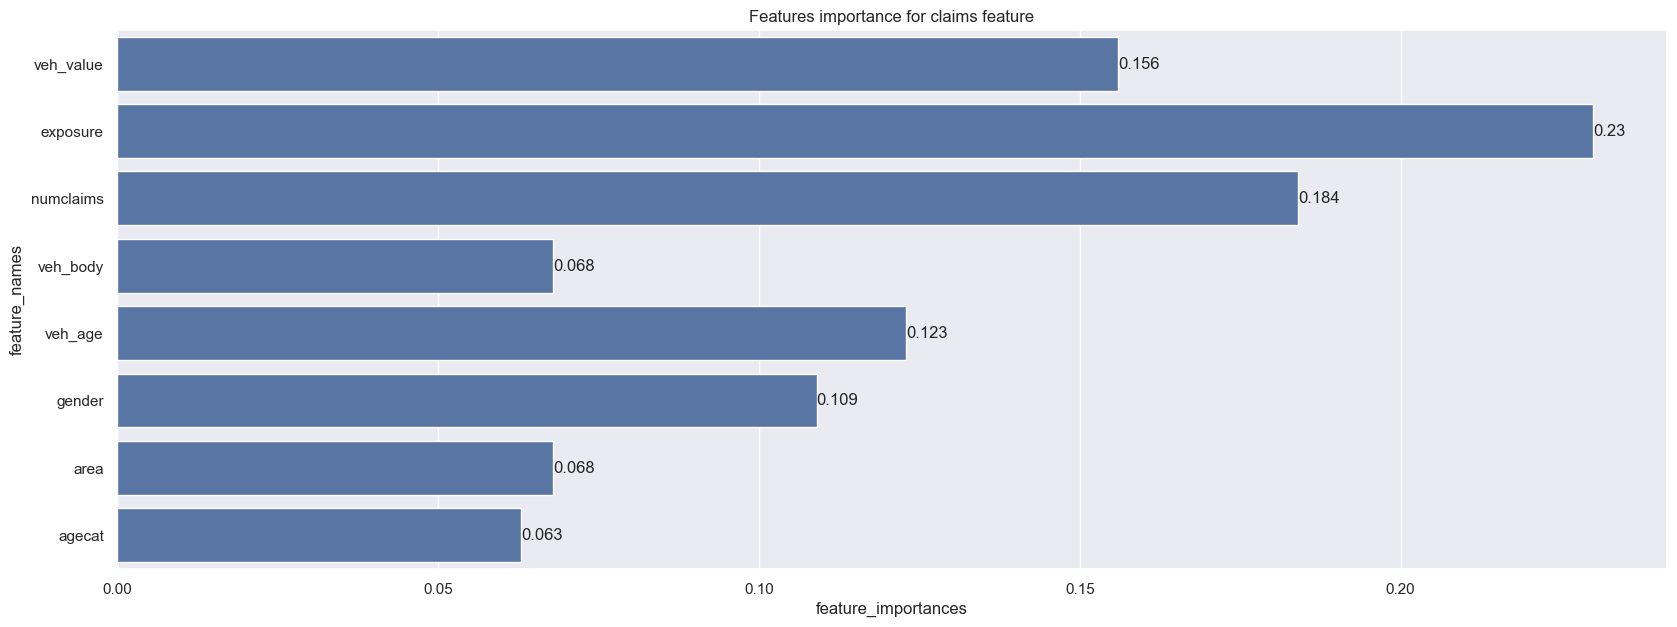

In [33]:
matplotlib.rcParams["figure.figsize"]=(20,7)
ax=sns.barplot(x=np.round(importance["feature_importances"],3),y=importance["feature_names"])
plt.title('Features importance for claims feature')
ax.bar_label(ax.containers[0]);
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/featuresImportanceGraphs/claims_featureImportanc.png',dpi=500);

In [34]:
import pickle
with open ("C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/bestModels/claims_prediction_model.pkl","wb") as f:
    pickle.dump(model,f)

---